In [1]:
from __future__ import print_function
from torchvision import models, transforms, datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
# from model import *
import matplotlib.pyplot as plt

import os
import sys
sys.path.append('./')

import numpy as np
from random import shuffle
from scipy.io import wavfile
from librosa import feature
from librosa.util import fix_length

import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

from scipy.stats import norm
import IPython


In [2]:
train_data_path = '/mnt/c/Dataset/asl-test-ir/train/'
test_data_path = '/mnt/c/Dataset/asl-alphabet/asl_alphabet_test'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_transforms = transforms.Compose([
    # transforms.Resize(32),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    # transforms.Resize(32),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(train_data_path, transform=train_transforms)

val_dataset = datasets.ImageFolder(train_data_path, transform=test_transforms)

In [3]:
from time import time
torch.manual_seed(time())
num_train_samples = len(train_dataset)
# num_train_samples = 20000

val_split = 0
split = int(num_train_samples * val_split)
indices = torch.randperm(num_train_samples)


train_subset = torch.utils.data.Subset(train_dataset, indices[split:])
val_subset = torch.utils.data.Subset(val_dataset, indices[:split])

len(train_subset), len(val_subset)

(13577, 0)

In [4]:
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_subset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=16
)

val_dataloader = torch.utils.data.DataLoader(
    dataset=val_subset,
    batch_size=4,
    shuffle=False,
    pin_memory=True,
    num_workers=16
)

classes = train_dataloader.dataset.dataset.classes

In [5]:
for img, label in val_dataloader:
    print(img.shape, label.shape)
    print(f'Ground Truth {classes[label[0]]}')
    print(img[0].size())
    print(img[0].permute(1, 2, 0).size())
    plt.imshow(img[0].permute(1, 2, 0), cmap='gray')
    break

In [6]:
model = torch.load("checkpoints-ir/checkpoint_97.57.pth", map_location='cpu')
model = model.to(device)
model.eval()
print(model)

myCNN_24(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (fc): Linear(in_features=384, out_features=29, bias=False)
)


[[483   0   0   0   1   0   0   0   0   0   0   0   8   0   0   0   0   0
    5   4   0   0   0   0   0   0   0]
 [  0 501   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0 501   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0 497   0   0   0   0   0   0   0   0   0   0   0   0   0   1
    0   0   1   0   0   0   0   1   0]
 [  0   0   0   0 500   0   0   0   0   0   0   0   1   0   1   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 509   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 502   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 501   0   0   0   0   0   0   0   0   1   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 501   0   0   0   0   0   0   0   0   0
    0   0   0   0   0 

Text(0.5, 80.7222222222222, 'predicted')

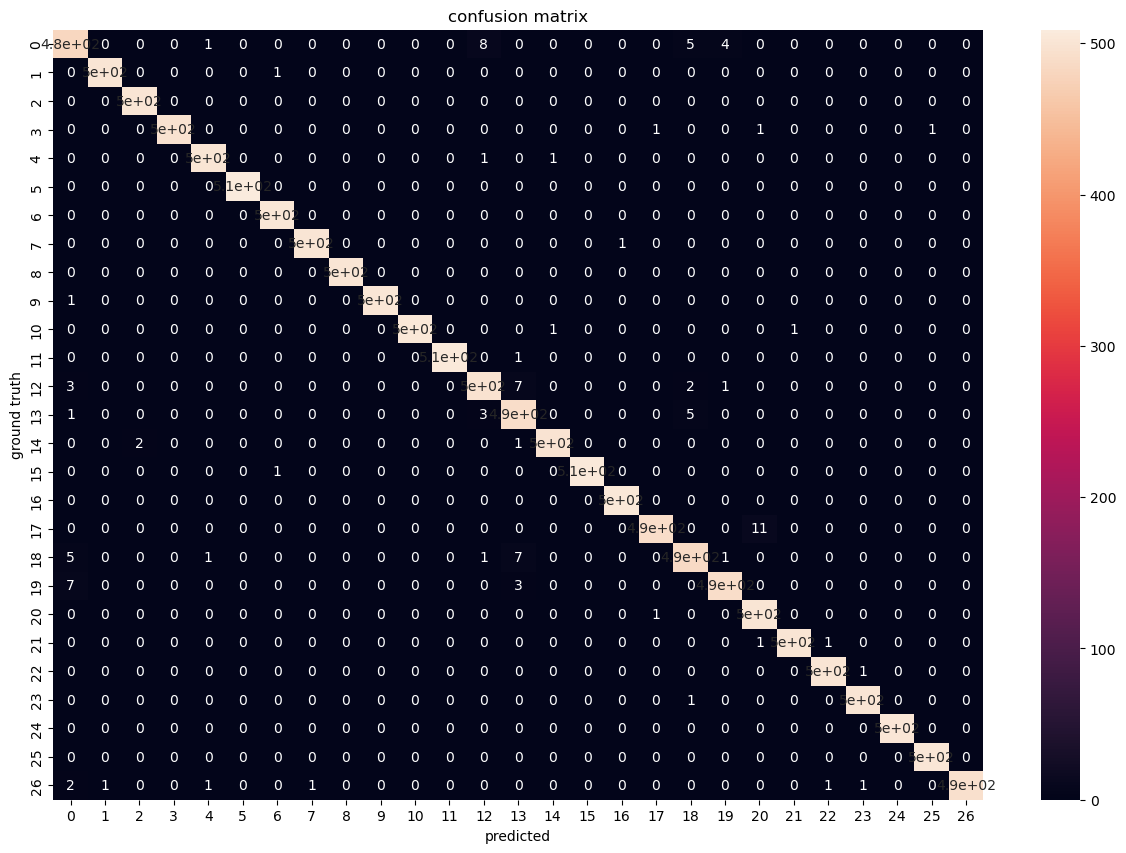

In [7]:
from sklearn.metrics import confusion_matrix

# List to store predictions and true labels
all_preds = []
all_labels = []

# Loop over the validation data loader
for batch in train_dataloader:
    # Unpack the data from the batch
    inputs, labels = batch
    # Move the data to the device
    inputs = inputs.to('cuda')
    labels = labels.to('cuda')
    # Forward pass and get the predicted labels
    with torch.no_grad():
        outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print(cm)

plt.figure(figsize = (15,10))
sn.heatmap(cm, annot=True)
plt.title("confusion matrix")
plt.ylabel("ground truth")
plt.xlabel("predicted")